In [1]:
import itertools
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [16.5, 5]

In [2]:
plt.rcParams['pdf.fonttype'] = 42
#plt.rcParams['font.family'] = 'Roboto Condensed'
matplotlib.rcParams.update({'font.size': 12})

In [3]:
import os
import json
import random
import csv
import copy
import scipy.stats as stats

## Setup

In [4]:
input_dir = '../../scratch/'

target_region = ('4', 3076604 - 500, 3076660 + 500)
target_repeat_unit = 'AGC'

### Load data

In [5]:
def overlaps(region_a, region_b):
    chrom_a, start_a, end_a = region_a
    chrom_b, start_b, end_b = region_b

    if chrom_a != chrom_b:
        return False

    overlap = max(0, min(end_a, end_b) - max(start_a, start_b))
    if overlap == 0:
        return False

    return True

In [6]:
def extract_anchored_irr_count(eh_denovo_out):
    if target_repeat_unit not in eh_denovo_out:
        return 0
    
    if 'RegionsWithIrrAnchors' not in eh_denovo_out[target_repeat_unit]:
        return 0
    
    total_anc_irr_count = 0
    for region, count in eh_denovo_out[target_repeat_unit]['RegionsWithIrrAnchors'].items():
        count = int(count)
        region = region.replace(':', '-').replace('-', '\t').split()
        region = (region[0], int(region[1]), int(region[2]))
        if overlaps(target_region, region):
            total_anc_irr_count += count
    
    return total_anc_irr_count


def extract_irr_pair_count(eh_denovo_out):
    if target_repeat_unit not in eh_denovo_out:
        return 0

    if 'IrrPairCount' not in eh_denovo_out[target_repeat_unit]:
        return 0
    
    num_irr_pair = int(eh_denovo_out[target_repeat_unit]['IrrPairCount'])
    return num_irr_pair

In [10]:
irr_counts = []

for run_dir in os.listdir(input_dir):
    if run_dir == 'README.md':
        continue

    expected_size = int(run_dir)
    
    for input_fname in os.listdir(input_dir + run_dir):
        if not input_fname.endswith('.str_profile.json'):
            continue

        replicate_num = int(input_fname.replace('.str_profile.json', ''))
        
        with open('{}/{}/{}'.format(input_dir, run_dir, input_fname), 'r') as eh_denovo_file:
            eh_out = json.load(eh_denovo_file)

        num_anchored_irrs = extract_anchored_irr_count(eh_out)
        num_irr_pairs = extract_irr_pair_count(eh_out)

        irr_counts.append({
                'expected_size' : expected_size,
                'num_anchored_irrs' : num_anchored_irrs,
                'num_irr_pairs' : num_irr_pairs,
                'replicate_num' : replicate_num
            })

irr_counts = DataFrame(irr_counts)
irr_counts.head()

,expected_size,num_anchored_irrs,num_irr_pairs,replicate_num
0,300,47,25,19
1,300,40,40,12
2,300,37,25,6
3,300,36,27,16
4,300,25,29,2


In [11]:
def generate_plotting_arrays(count_table):
    
    arrays = {'sizes': [], 'air_counts': [], 'pir_counts': []}
    
    for size, group in count_table.groupby('expected_size'):        
        arrays['sizes'].append(size)
        arrays['air_counts'].append(list(group.num_anchored_irrs))
        arrays['pir_counts'].append(list(group.num_irr_pairs))
    
    return arrays

In [12]:
def draw_boxplots(ax, sizes, counts):
    flierprops = dict(marker='o', markerfacecolor='#5e3c99', markersize=3, linestyle='none')
    
    ax.axvline(x=150/3, color='#fdb863', label='Read length')
    ax.axvline(x=350/3, color='#e66101', label='Mean fragment length')
    
    ax.boxplot(counts,
               positions=sizes,
               patch_artist=True,
               boxprops = {'color': '#5e3c99', 'facecolor': '#5e3c99'},
               medianprops = {'color': '#b2abd2', 'linewidth': 0},
               whiskerprops = {'color': '#5e3c99'},
               showcaps=False,
               widths=0.7,
               flierprops=flierprops)
    
    start, end = min(plotting_arrays['sizes']), max(plotting_arrays['sizes']) + 1
    ax.set_xticks(np.arange(start, end, 10))
    ax.set_xticklabels(np.arange(start, end, 10))
    
    ax.legend();

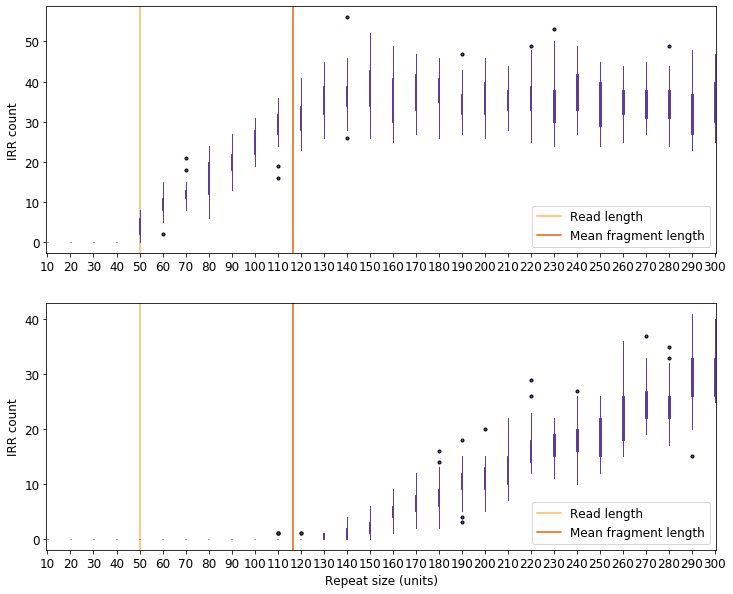

In [14]:
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

plotting_arrays = generate_plotting_arrays(irr_counts)
draw_boxplots(ax1, plotting_arrays['sizes'], plotting_arrays['air_counts'])
draw_boxplots(ax2, plotting_arrays['sizes'], plotting_arrays['pir_counts'])


ax1.set_ylabel('IRR count')
ax2.set_ylabel('IRR count')
ax2.set_xlabel('Repeat size (units)');